In [11]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import cv2
from skimage import io, exposure
from matplotlib import pyplot as plt

In [2]:
%%javascript

// Disable Scrolling windows for big cell outputs
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Band 5 - NIR: Good for growing vegetation**
Try: (Green - Red - NIR)
![](https://www.researchgate.net/profile/Muhammad_Fahmi_Razali/publication/270511699/figure/fig1/AS:392169782300676@1470511970680/Figure-1-The-spectral-bands-of-Landsat-8-OLI-and-TIRS-compared-to-Landsat-7-ETM.png)

In [3]:
import os

data_dir_name = 'LC08_L1TP_220071_20160409_20170326_01_T1'
data_dir_path = './GPAM_dataset/LC08_L1TP_220071_20160409_20170326_01_T1/'

def read_band(directory, n):
    if n in range(1, 12):
        band_path = directory + data_dir_name + '_B' + str(n) + '.TIF'
        if (os.path.isfile(band_path)):
            img = io.imread(band_path)
            print('Image:', band_path)            
            return img
        else:
            print('Image:', band_path, 'not found!')
    else:
        print('Band number has to be in the range 1-11!')

read_band(data_dir_path, 8)

Image: ./GPAM_dataset/LC08_L1TP_220071_20160409_20170326_01_T1/LC08_L1TP_220071_20160409_20170326_01_T1_B8.TIF


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [4]:
%%time
import re
from math import pow

def show_image(img, title):
    fig = plt.figure(figsize=(12, 12))
    fig.set_facecolor('white')    
    img_dim = pow(2, get_image_dimension(img)) - 1
    plt.imshow(img/img_dim)
    plt.title(title)
    plt.show()

def get_image_dimension(img):
    dim = re.findall(r'\d+', str(img.dtype))
    dim = int(dim[0])
    return dim

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.2 µs


In [5]:
def stack_bands(directory, *args):
    b = []
    for idx, band in enumerate(args):
        b.append(read_band(directory, band))
    stack = np.dstack(b)
    return stack

In [6]:
rgb = stack_bands(data_dir_path, 4, 3, 2)

img_765 = stack_bands(data_dir_path, 7, 6, 5)

# 543: Good for growing vegetation.
img_543 = stack_bands(data_dir_path, 5, 4, 3)

panchr = read_band(data_dir_path, 8)

Image: ./GPAM_dataset/LC08_L1TP_220071_20160409_20170326_01_T1/LC08_L1TP_220071_20160409_20170326_01_T1_B4.TIF
Image: ./GPAM_dataset/LC08_L1TP_220071_20160409_20170326_01_T1/LC08_L1TP_220071_20160409_20170326_01_T1_B3.TIF
Image: ./GPAM_dataset/LC08_L1TP_220071_20160409_20170326_01_T1/LC08_L1TP_220071_20160409_20170326_01_T1_B2.TIF
Image: ./GPAM_dataset/LC08_L1TP_220071_20160409_20170326_01_T1/LC08_L1TP_220071_20160409_20170326_01_T1_B7.TIF
Image: ./GPAM_dataset/LC08_L1TP_220071_20160409_20170326_01_T1/LC08_L1TP_220071_20160409_20170326_01_T1_B6.TIF
Image: ./GPAM_dataset/LC08_L1TP_220071_20160409_20170326_01_T1/LC08_L1TP_220071_20160409_20170326_01_T1_B5.TIF
Image: ./GPAM_dataset/LC08_L1TP_220071_20160409_20170326_01_T1/LC08_L1TP_220071_20160409_20170326_01_T1_B5.TIF
Image: ./GPAM_dataset/LC08_L1TP_220071_20160409_20170326_01_T1/LC08_L1TP_220071_20160409_20170326_01_T1_B4.TIF
Image: ./GPAM_dataset/LC08_L1TP_220071_20160409_20170326_01_T1/LC08_L1TP_220071_20160409_20170326_01_T1_B3.TIF
I

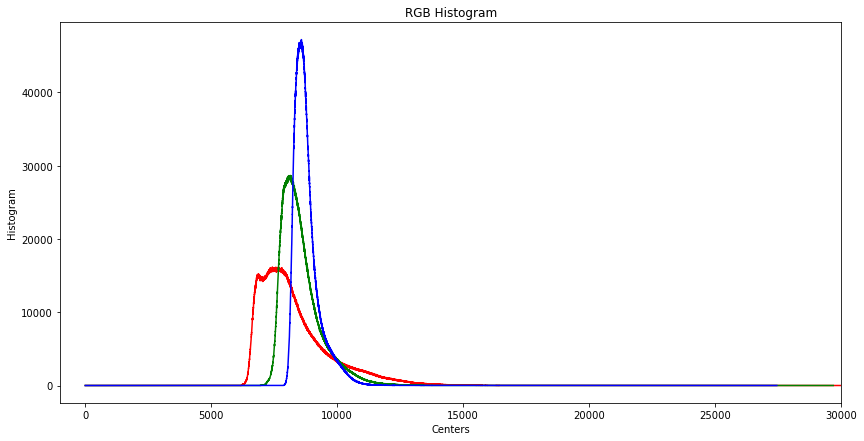

CPU times: user 752 ms, sys: 112 ms, total: 864 ms
Wall time: 863 ms


In [68]:
%%time
#other function: get image dimension and cut % of frequency desired (not null)
def rgb_histogram(image):
    fig = plt.figure(figsize=(14, 7))
    fig.set_facecolor('white')

    for color, channel in zip('rgb', np.rollaxis(image, axis=-1)):
        hist, centers = exposure.histogram(channel)
        plt.plot(centers[1::], hist[1::], color=color)
        img_hist = np.column_stack((centers, hist))

    plt.title('RGB Histogram')
    plt.xlim(-1000, 30000)
    plt.xlabel('Centers')
    plt.ylabel('Histogram')
    plt.show()
    
rgb_histogram(rgb)

In [52]:
%%time
def equalize_color_image(img):
    eq_img = np.empty(img.shape, dtype=img.dtype)
    b = img[:,:,2]
    g = img[:,:,1]
    r = img[:,:,0]

    r_min = np.amin(r[np.nonzero(r)])
    r_max = np.amax(r)
    
    g_min = np.amin(g[np.nonzero(g)])
    g_max = np.amax(g)
    
    b_min = np.amin(b[np.nonzero(b)])
    b_max = np.amax(b)
    
#     ARRUMAR OS LIMITES ^
    print('R, G, B min and max respectively:', r_min, r_max, g_min, g_max, b_min, b_max)
    
    lims = [(b_min, b_max), (g_min, g_max), (r_min, r_max)]
    for lim, channel in zip(lims, range(3)):
        eq_img[:, :, channel] = exposure.rescale_intensity(img[:, :, channel], lim)
    return eq_img

eq_rgb = equalize_color_image(img_765)
# show_image(rgb, 'EQ RGB')

R, G, B min and max respectively: 4832 65535 4656 46510 4994 53109
CPU times: user 3.11 s, sys: 420 ms, total: 3.53 s
Wall time: 3.53 s


## Image Histogram Equalization

![](http://opencv-python-tutroals.readthedocs.io/en/latest/_images/histogram_equalization.png)

Key expressions:   

**CDF** ([Cumulative Distribution Function](https://en.wikipedia.org/wiki/Cumulative_distribution_function)):  
The equalized CDF is defined in terms of rank as *rank/pixelcount*

The pixel with minimum value at the unequalized image will become 0 and the one with the maximum value will become 255

**CLAHE (Contrast Limited Adaptive Histogram Equalization)**:   
Best when the image histogram is not confined to a particular region


In [44]:
def plot_histogram(*images):
    for index, img in enumerate(images):
        hist,bins = np.histogram(img.flatten(),256,[0,256])

        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max()/ cdf.max()

        plt.figure(figsize=(8,4))
        plt.plot(cdf_normalized, color = 'c')
        plt.hist(img.flatten(),256,[0,256], color = 'k')
        plt.xlim([0,256])
        plt.legend(('cdf','histogram'), loc = 'upper left')
        plt.title('Image ' + str(index + 1))
        plt.show()

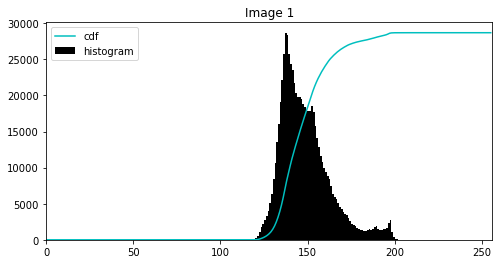

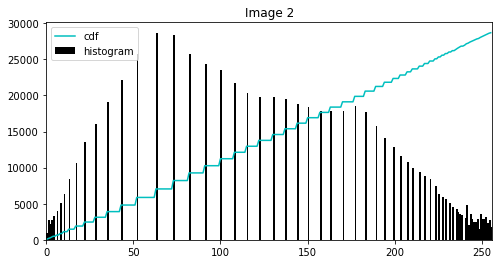

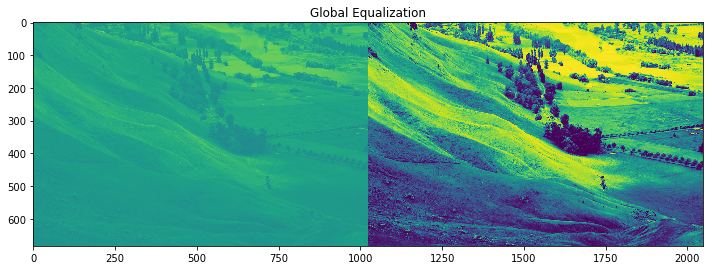

array([[  6, 130, 157, ..., 233, 231, 229],
       [227, 177, 115, ..., 233, 235, 233],
       [237, 130,  91, ..., 199, 189, 170],
       ..., 
       [144,  22,  35, ..., 137, 130, 122],
       [137,  13,  22, ..., 137, 130, 122],
       [130,   8,  10, ..., 137, 130, 122]], dtype=uint8)

In [47]:
def equalize_image(img):
    equ = cv2.equalizeHist(img)
    plot_histogram(img, equ)
    res = np.hstack((img,equ)) #stacking images side-by-side
    show_image(res, 'Global Equalization')
    return equ

img = cv2.imread('./Imagens/Unequalized_Hawkes_Bay_NZ.jpg', 0)
equalize_image(img)

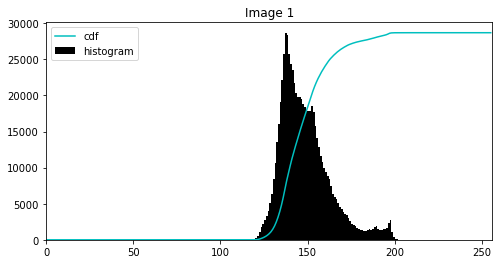

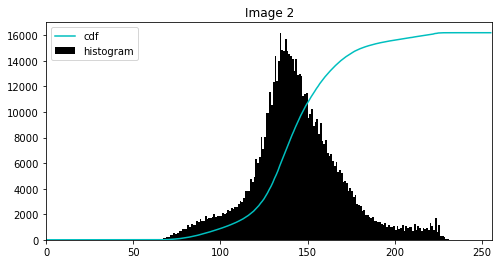

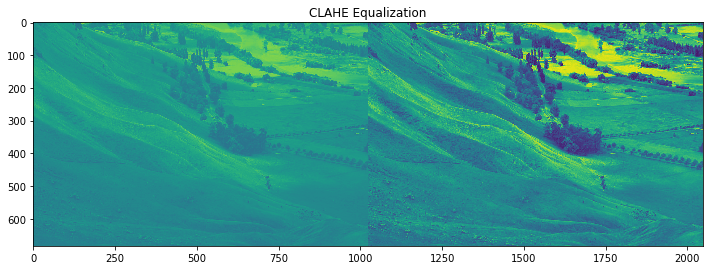

array([[ 98, 133, 144, ..., 168, 166, 163],
       [185, 152, 127, ..., 168, 171, 168],
       [191, 133, 119, ..., 139, 134, 126],
       ..., 
       [166, 126, 131, ..., 157, 155, 152],
       [164, 120, 126, ..., 157, 155, 152],
       [161, 114, 117, ..., 157, 155, 152]], dtype=uint8)

In [48]:
def equalize_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    plot_histogram(img, cl1)
    res = np.hstack((img,cl1)) #stacking images side-by-side
    show_image(res, 'CLAHE Equalization')
    return cl1

equalize_clahe(img)

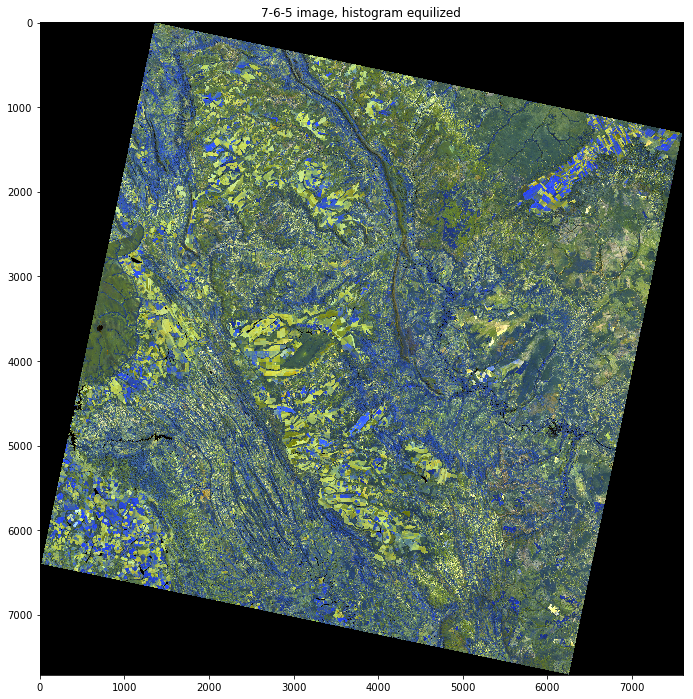

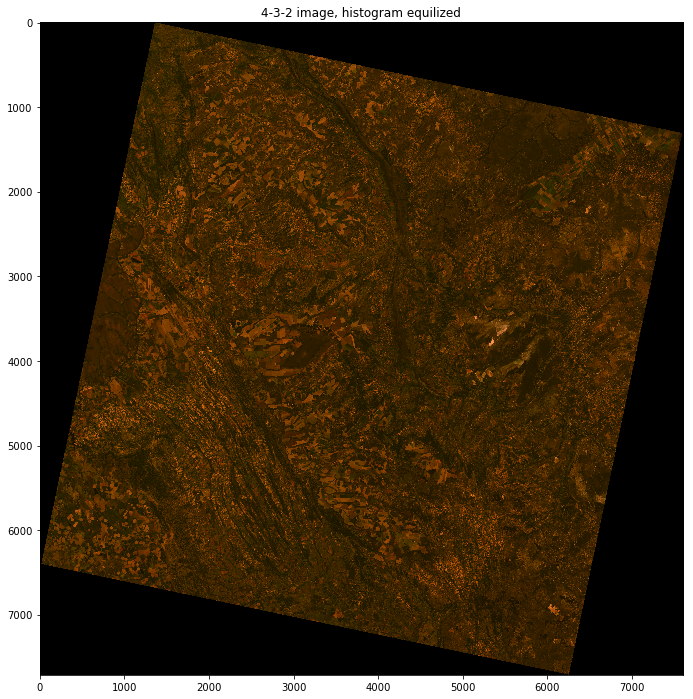

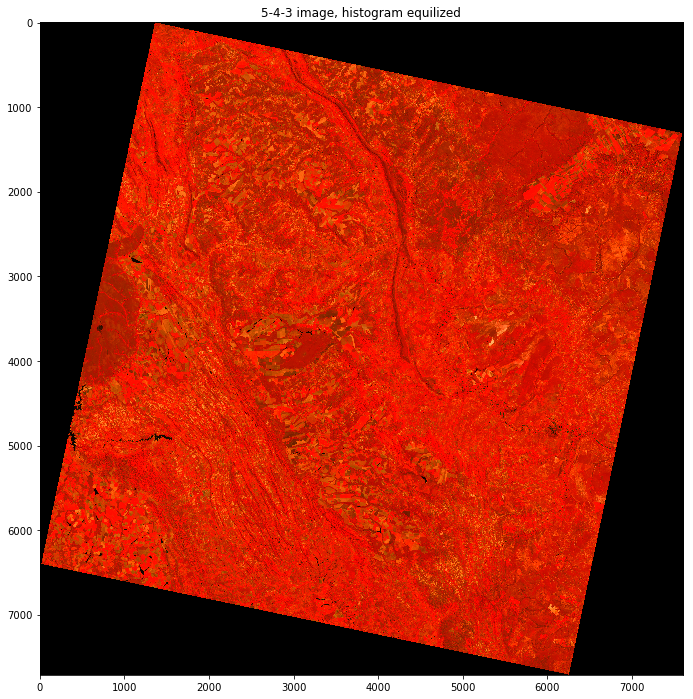

In [82]:
eq_img_765 = equalize_color_image(img_765)
show_image(eq_img_765, '7-6-5 image, histogram equilized')

eq_img_432 = equalize_color_image(rgb)
show_image(eq_img_432, '4-3-2 image, histogram equilized')

eq_img_543 = equalize_color_image(img_543)
show_image(eq_img_543, '5-4-3 image, histogram equilized')

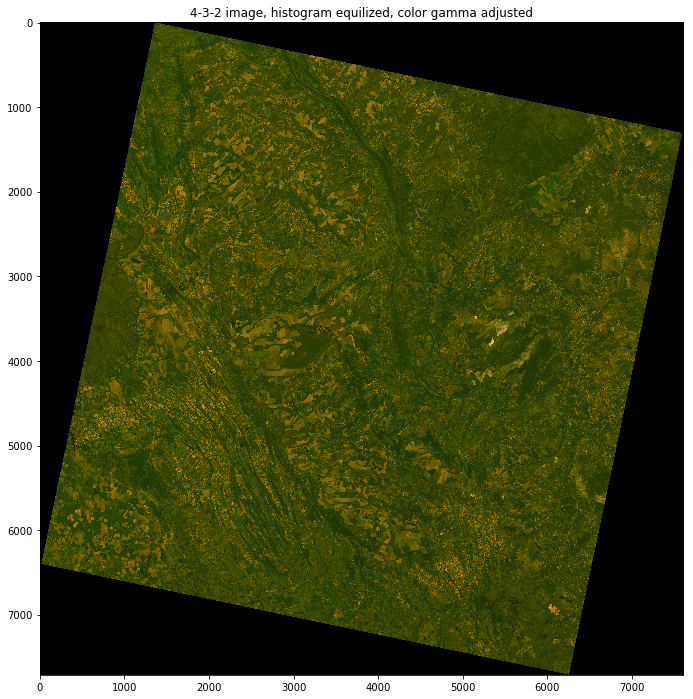

In [69]:
# calculate image NDVI and LFT
def adjust_gamma(image):
    image[:, :, 1] = exposure.adjust_gamma(image[:, :, 1], 0.65)
    image[:, :, 2] = exposure.adjust_gamma(image[:, :, 2], 0.75)
    return image

adj_image = adjust_gamma(eq_img_432)
show_image(adj_image, '4-3-2 image, histogram equilized, color gamma adjusted')

### Calculate NDVI

In this [link](https://www.planet.com/docs/guides/quickstart-ndvi/) has a explanation of normalize reflectance for more accuracy in NDVI.

In [14]:
import xml

In [18]:
os.listdir(data_dir_path)

['LC08_L1TP_220071_20160409_20170326_01_T1_B4.TIF',
 'LC08_L1TP_220071_20160409_20170326_01_T1_B8.TIF',
 'LC08_L1TP_220071_20160409_20170326_01_T1_B11.TIF',
 'LC08_L1TP_220071_20160409_20170326_01_T1_B7.TIF',
 'LC08_L1TP_220071_20160409_20170326_01_T1_B3.TIF',
 'LC08_L1TP_220071_20160409_20170326_01_T1_B1.TIF',
 'LC08_L1TP_220071_20160409_20170326_01_T1_BQA.TIF',
 'LC08_L1TP_220071_20160409_20170326_01_T1_MTL.txt',
 'LC08_L1TP_220071_20160409_20170326_01_T1_B9.TIF',
 'LC08_L1TP_220071_20160409_20170326_01_T1_B5.TIF',
 'LC08_L1TP_220071_20160409_20170326_01_T1_ANG.txt',
 'LC08_L1TP_220071_20160409_20170326_01_T1_B2.TIF',
 'LC08_L1TP_220071_20160409_20170326_01_T1_B6.TIF',
 'LC08_L1TP_220071_20160409_20170326_01_T1_B10.TIF']

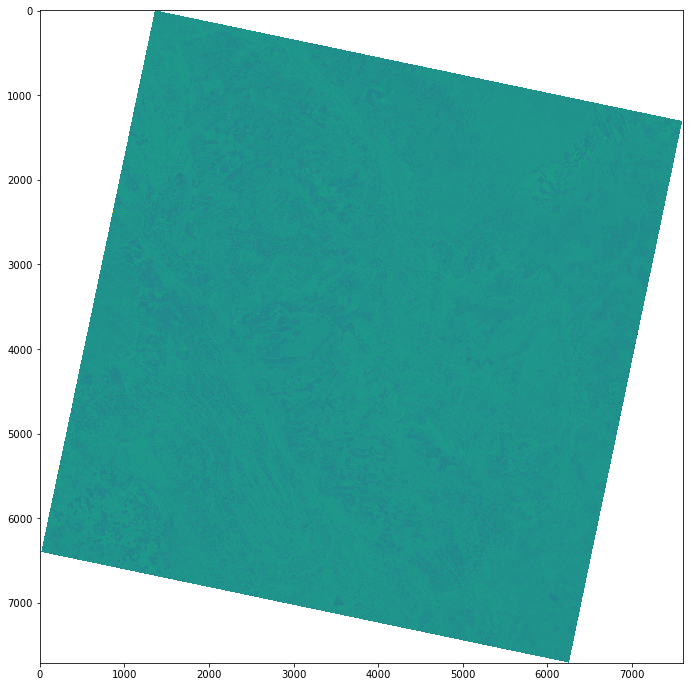

In [21]:
def calc_ndvi(img):
    
    vis = img[:,:,0].astype(float)
    nir = img[:,:,1].astype(float)

    
    # Allow x/0
    np.seterr(divide='ignore', invalid='ignore')
    ndvi = np.divide(nir-vis,nir+vis)
    
    return ndvi

ndvi_rgb = calc_ndvi(rgb)
show_image(ndvi_rgb, '')